# Imports

In [1]:
from configuration.paths import *

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from src.datasets.chest_xray import ChestXRay
from src.utils.schemes import Scheme
from src.utils.image import Image

# Dataset loading for training

In [2]:
IMAGE_SIZE = (256, 256)

In [3]:
cx = ChestXRay(DATASET_CHEST_XRAY_PATH, IMAGE_SIZE)

In [4]:
Scheme.dataset_info(cx)

Train:
 - Normal: 1341
 - Pneumonia: 1938
Test:
 - Normal: 234
 - Pneumonia: 390
Val:
 - Normal: 8
 - Pneumonia: 8


In [5]:
x_train, y_train, _ = cx.load_train_data()
x_train = x_train / 255.0

x_val, y_val, _ = cx.load_val_data()
x_val = x_val / 255.0

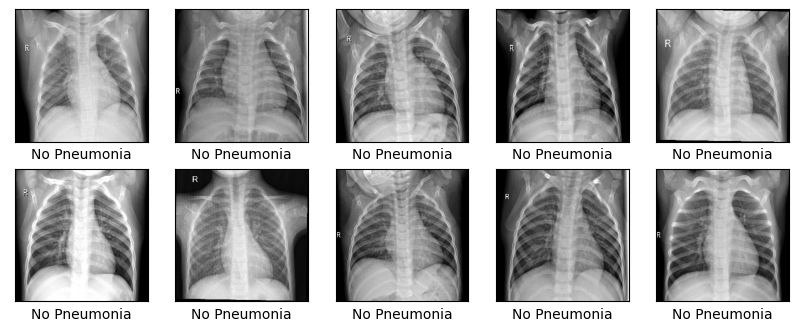

In [6]:
Scheme.labeled_images(x_train, y_train)

# Mdel definition

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(filters=8, activation='relu', kernel_size=3, padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=8, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=16, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=32, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4

In [9]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])

# Model training

In [10]:
aug = ImageDataGenerator(rotation_range=45, zoom_range=0.3,
						width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
						vertical_flip=True, horizontal_flip=True, fill_mode="nearest")

history = model.fit(aug.flow(x_train, y_train, batch_size=16),
					validation_data=(x_val, y_val),
					epochs=50)

Epoch 1/50
205/205 [==============================] - 32s 149ms/step - loss: 0.5925 - binary_accuracy: 0.6727 - precision: 0.6776 - recall: 0.8578 - val_loss: 0.5142 - val_binary_accuracy: 0.6250 - val_precision: 0.5833 - val_recall: 0.8750
Epoch 2/50
205/205 [==============================] - 30s 147ms/step - loss: 0.3933 - binary_accuracy: 0.8440 - precision: 0.8860 - recall: 0.8404 - val_loss: 0.6123 - val_binary_accuracy: 0.6250 - val_precision: 0.5833 - val_recall: 0.8750
Epoch 3/50
205/205 [==============================] - 29s 142ms/step - loss: 0.3979 - binary_accuracy: 0.8504 - precision: 0.8996 - recall: 0.8398 - val_loss: 0.4782 - val_binary_accuracy: 0.6875 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 4/50
205/205 [==============================] - 29s 141ms/step - loss: 0.3724 - binary_accuracy: 0.8466 - precision: 0.8932 - recall: 0.8444 - val_loss: 0.5260 - val_binary_accuracy: 0.6875 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 5/50
205/205 [================

<Figure size 640x480 with 0 Axes>

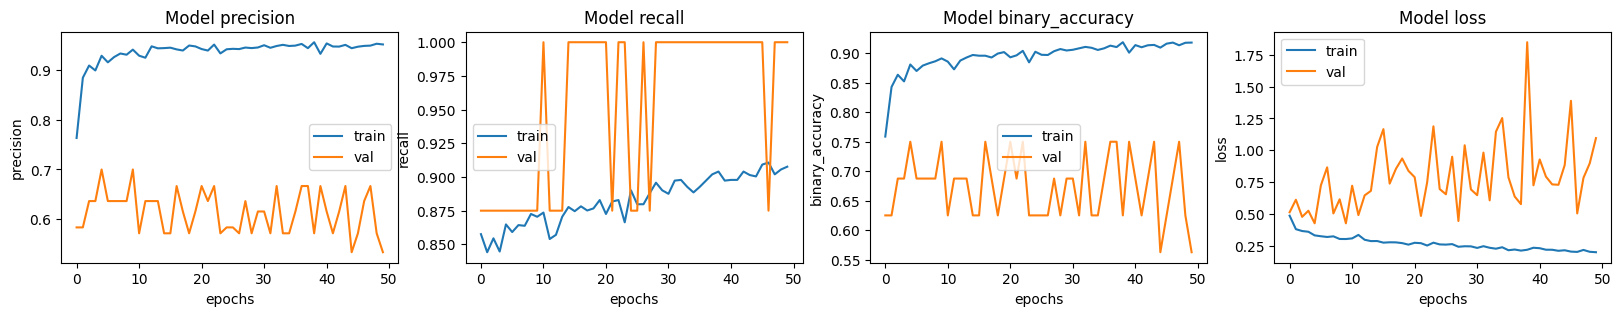

In [11]:
Scheme.training_graphs(history)

In [12]:
del x_train
del y_train

# Evaluating the model

In [13]:
x_test, y_test, diagnosis = cx.load_test_data()
x_test = x_test / 255.0

In [14]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 9ms/step - loss: 0.3795 - binary_accuracy: 0.8910 - precision: 0.8744 - recall: 0.9641


In [ ]:
images = [x_test[10], x_test[11], x_test[55], x_test[67], x_test[60],
          x_test[202], x_test[203], x_test[206], x_test[217], x_test[220]]
labels = [1, 1, 1, 1, 1,
          0, 0, 0, 0, 0]
images = Image.explainer(images, model, IMAGE_SIZE)

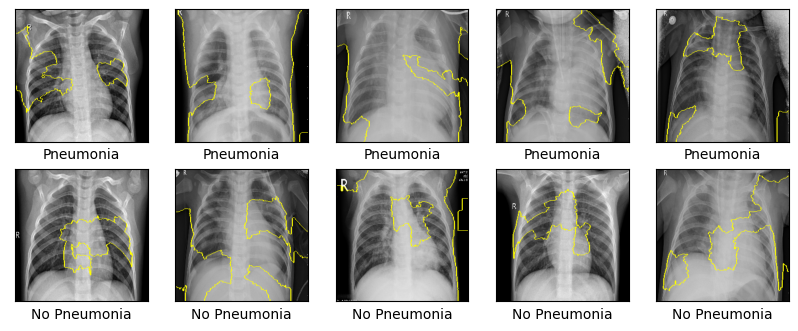

In [16]:
Scheme.labeled_images(images, labels)

In [17]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

<Figure size 640x480 with 0 Axes>

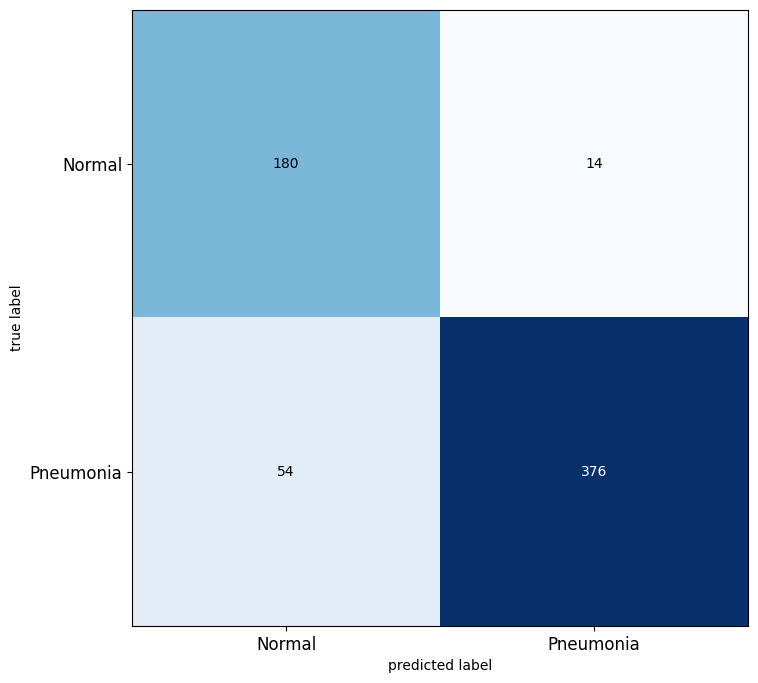

In [18]:
Scheme.confusion_matrix(predictions_rounded, cx.get_test_df().diagnosis.to_numpy())